In [36]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image


In [59]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def get_patches(im, w, h, padding):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight-padding*2,h):
        for j in range(0,imgwidth-padding*2,w):
            if is_2d:
                im_patch = im[j:j+w+padding*2, i:i+h+padding*2]
            else:
                im_patch = im[j:j+w+padding*2, i:i+h+padding*2, :]
            list_patches.append(im_patch)
    return list_patches

## Load the data

In [60]:
# Loaded a set of images
root_dir = "datas/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(5, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 5 images
satImage_001.png
Loading 5 groundtruth
satImage_001.png


## Data Exploration

Image size = 400,400


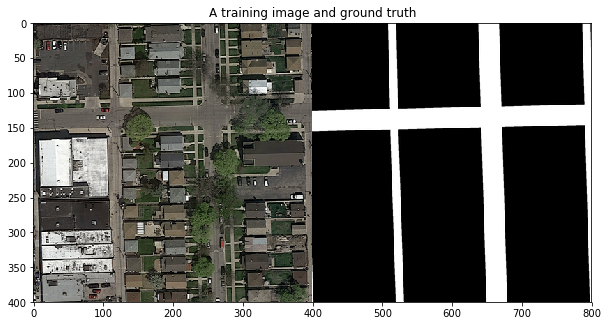

In [61]:
image = imgs[3]
gt_image = gt_imgs[3]
print('Image size = ' + str(image.shape[0]) + ',' + str(image.shape[1]))
fig1 = plt.figure(figsize=(10, 10))
plt.title("A training image and ground truth")
plt.imshow(concatenate_images(image, gt_image), cmap='Greys_r');


We observe that the road we need to label can be a difficult task. The variety of colors and obstacles is high : 
- Trees
- Cars
- Asphalt color

There are 625 patches of 16*16 for the image


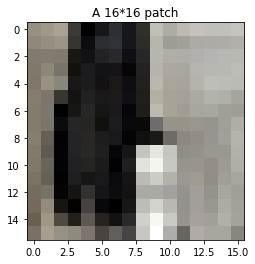

In [62]:
patch_size = 16
img_patches = get_patches(image, patch_size, patch_size, 0)
plt.title('A 16*16 patch')

print("There are", len(img_patches), "patches of 16*16 for the image")
plt.imshow(img_patches[5], cmap='Greys_r');

Our task is to label each of these 16\*16 patch.  
On the example above can be either some obstacle, a car, or an element of a roof.


However, this small size of portion of the image can miss some context. We need to expand this by adding some padding around it. 


## Padding

Instead of taking the raw 16\*16 patch, we can take a larger patch (padded patch) and then classify the 16\*16 center of that expanded patch.

In order to do that on the border of the image, we have to expand it. One of the way to do that is to mirroring the image

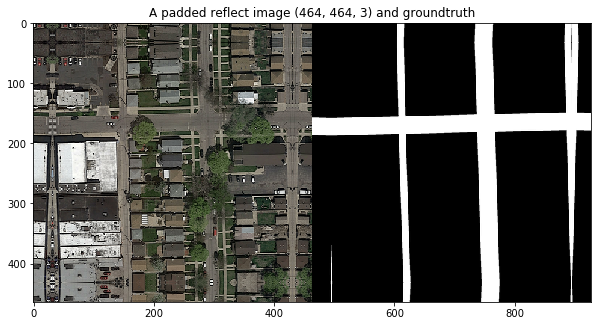

In [63]:
padding = 32
padded_patch_size = patch_size + padding*2
padded_image = np.lib.pad(image, ((padding, padding), (padding, padding), (0,0)), 'reflect')
padded_gt_image = np.lib.pad(gt_image, ((padding, padding), (padding, padding)), 'reflect')

fig1 = plt.figure(figsize=(10, 10))
plt.title("A padded reflect image " + str(padded_image.shape) + " and groundtruth")
plt.imshow(concatenate_images(padded_image, padded_gt_image), cmap='Greys_r');

There are 625 patches of 80*80 for the image


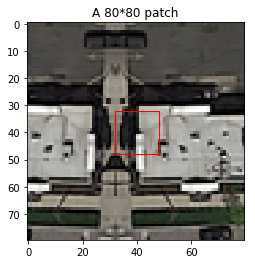

In [69]:
padded_img_patches = get_patches(padded_image, patch_size, patch_size, padding)

print("There are", len(padded_img_patches), 'patches of ' + str(padded_patch_size) + '*' +  str(padded_patch_size) + ' for the image')


fig,ax = plt.subplots(1)
plt.title('A ' + str(padded_patch_size) + '*' +  str(padded_patch_size) + ' patch')

plt.imshow(padded_img_patches[5], cmap='Greys_r');
rect = patches.Rectangle((padding,padding), patch_size, patch_size,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

Now we can see clearly that the center (the image inside the red square)of this padded image is not a road.

## Data augmentation
The dataset contains only 100 examples.
In order to increase the dataset, we can do the following transformation : 
- 90 degree rotation
- Horizontal flip
- Vertical flip

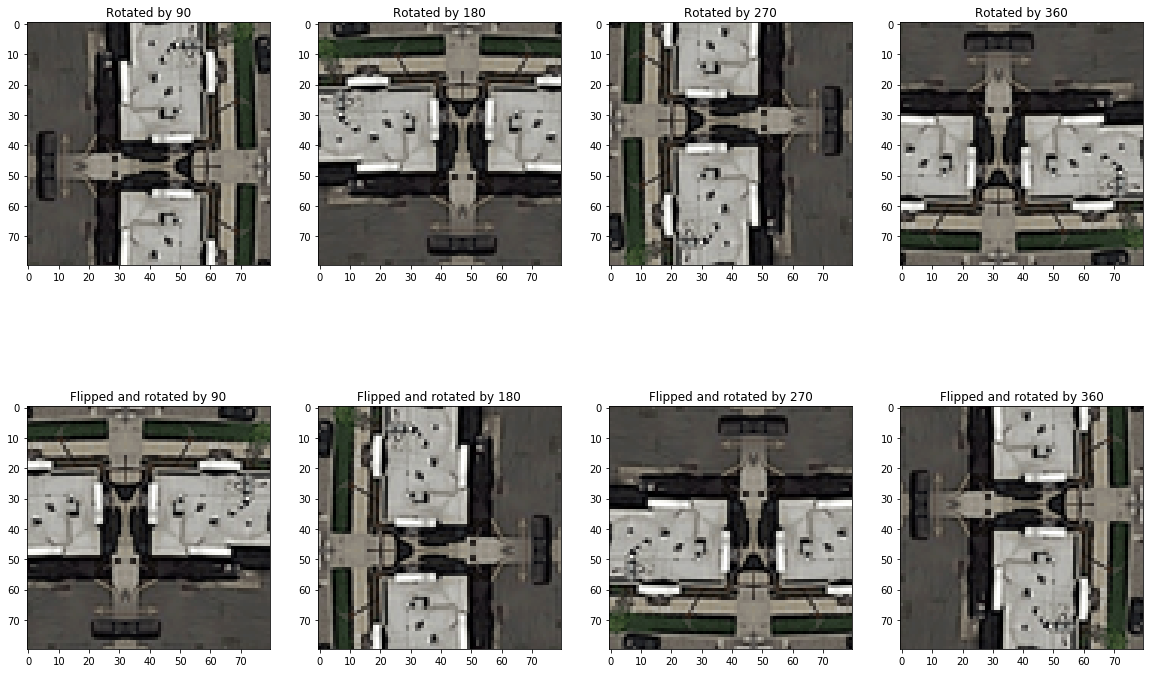

In [70]:
image_to_transform = padded_img_patches[5]
transformed_images = [np.rot90(image_to_transform, i+1) for i in range(4)]

for i in range(4):
    transformed_images.append(np.rot90(np.flip(image_to_transform, 0), i))


plt.figure(figsize=(20,20))
columns = 4
for i, image in enumerate(transformed_images):
    plt.subplot(len(transformed_images) / columns + 1, columns, i + 1)
    
    if i < 4:
        plt.title('Rotated by ' +str((i+1)*90))
    else:
        plt.title('Flipped and rotated by ' +str((i-3)*90))
    
    plt.imshow(image)

625


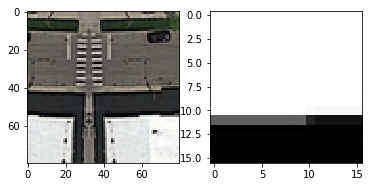

In [71]:
patch_size = 16
gt_img_patches = get_patches(gt_image, patch_size, patch_size, 0)
print(len(gt_img_patches))

patch_index = 9

plt.subplot(1, 2, 1)
plt.imshow(padded_img_patches[patch_index], cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.imshow(gt_img_patches[patch_index], cmap='Greys_r')

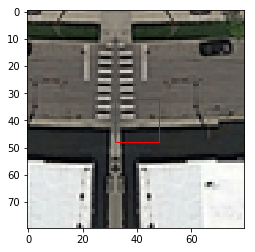

In [78]:
fig,ax = plt.subplots(1)
ax.imshow(padded_img_patches[patch_index])
rect = patches.Rectangle((padding,padding), patch_size, patch_size,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()